### Polar rectify main program

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:96: RuntimeWarning: invalid value encountered in arccos


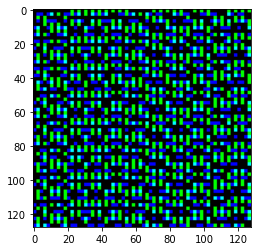

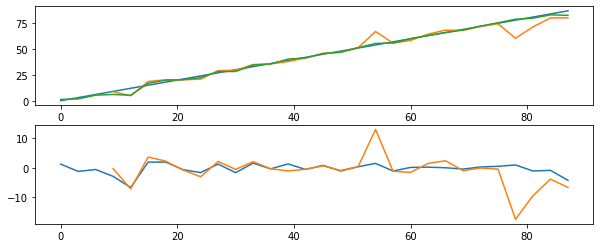

In [159]:
import numpy as np
import math
from matplotlib import pyplot as plt
import cv2
from scipy import ndimage

isPlot=False
idDebug=False

def imgWrapA(orgImg,a):
    img_a = ndimage.rotate(orgImg, a, reshape=False)    
    return img_a


def twoLinesFFT_maxFreq(img, line1_index, line2_index):
    if idDebug:
        print(line1_index,line2_index)
    line1=img[:,line1_index]
    line2=img[:,line2_index]
    lineSum=line1+line2
    img_0_fft=np.fft.fft(lineSum*1.0)
    img_0_fft_abs=np.abs(img_0_fft)
    MaxFreq=np.argmax(img_0_fft_abs[1:32])+1
    x = np.array([MaxFreq-1.0, MaxFreq, MaxFreq+1])
    y = np.array([img_0_fft_abs[MaxFreq-1], img_0_fft_abs[MaxFreq], img_0_fft_abs[MaxFreq+1]])
    z = np.polyfit(x, y, 2)
    EstMaxFreq=-0.5*z[1]/z[0]
    if isPlot:
        plt.subplots(1,1,figsize=(10,2))
        plt.subplot(121)
        plt.plot(line1, label = "line1")
        plt.plot(line2,   label = "line2")
        plt.plot(lineSum, label = "lineSum")
        plt.legend()
        plt.subplot(122)
        plt.imshow(img[:,line1_index:line1_index+32]+img[:,line2_index:line2_index+32], cmap = 'gray')
        plt.show()

    return EstMaxFreq
    

def getTargetArray(orgImg, color, offset):
    wh=orgImg.shape[0]
    #print(wh)
    avgDists=np.array(orgImg[0:int(wh/2), int(wh/2)+offset,color])*1.0
    #print(avgDists)
    maxIndex_list_minus=(-avgDists).argsort()
    usedArray=[]
    targetArray=[]
    desiredTargetArrayCount=0
    targetArrayWeight=0
    MaxDesiredTargetArrayCount = 3

    #print('maxIndex_list_minus=', maxIndex_list_minus)

    for i in range(10):
        if maxIndex_list_minus[i] not in usedArray:
            ######pix_color_1 = np.array(orgImg[maxIndex_list_minus[i]:maxIndex_list_minus[i]+int(wh/2),:])
            targetArray.append(maxIndex_list_minus[i])
            usedArray.append(maxIndex_list_minus[i]-2)
            usedArray.append(maxIndex_list_minus[i]-1)
            usedArray.append(maxIndex_list_minus[i])
            usedArray.append(maxIndex_list_minus[i]+1)
            usedArray.append(maxIndex_list_minus[i]+2)
            desiredTargetArrayCount +=1
            targetArrayWeight += avgDists[maxIndex_list_minus[i]]
        if desiredTargetArrayCount > MaxDesiredTargetArrayCount:
            break
    if idDebug:
        print(wh)
        print(avgDists)
        print(usedArray, targetArray, desiredTargetArrayCount)
    return targetArray, targetArrayWeight
    
def img_horizontal_Freq(orgImg, color=1):
    targetArray, targetArrayWeight = getTargetArray(orgImg, 1, 0)
    targetArray1, targetArrayWeight1 = getTargetArray(orgImg, 1, 1)
    if targetArrayWeight1 > targetArrayWeight:
        targetArray = targetArray1
    targetArray2, targetArrayWeight2 = getTargetArray(orgImg, 1, 2)
    if targetArrayWeight2 > targetArrayWeight:
        targetArray = targetArray2
    pix_color = np.array(orgImg)
    img=pix_color[:,:,color]*1.0
    f=np.zeros(3)
    f[0]=twoLinesFFT_maxFreq(img,targetArray[0],targetArray[1])
    f[1]=twoLinesFFT_maxFreq(img,targetArray[0],targetArray[2])
    f[2]=twoLinesFFT_maxFreq(img,targetArray[2],targetArray[1])
    if idDebug:
        print('f=',f)
    return np.median(f)

    
def estCorrect_deepracer(orgImg, color=1):
    green_freq=img_horizontal_Freq(cv2.rotate(orgImg, cv2.cv2.ROTATE_90_CLOCKWISE), 1)
    green_angle=np.arccos(green_freq/16)* 180 / np.pi
    
    blue_freq=img_horizontal_Freq(orgImg, 2)
    blue_angle=np.arccos(blue_freq/16)* 180 / np.pi
    
    est_angle=np.arctan2(green_freq,blue_freq)* 180 / np.pi
    return [green_angle,blue_angle]

        
def test_gen(a):
    bigMap="img/2018_org_narrow_2.tiff"
    orgImg = cv2.cvtColor(cv2.imread(bigMap), cv2.COLOR_BGR2RGB)

    #Question
    y=150;
    x=210;
    wh=128
    orgImg_crop128=orgImg[y: y + wh, x: x + wh ]
    plt.imshow(orgImg_crop128)
    orgImg_crop128_a33=imgWrapA(orgImg_crop128,a)
    offset=0
    orgImg_crop128_a33_crop=orgImg_crop128_a33[int(wh/4)+offset: int(3*wh/4)+offset , int(wh/4): int(3*wh/4)]

    return orgImg_crop128_a33_crop


##### Test #####
result=np.zeros([30,3])
i=0
for a in range(0,90,3):
    result[i,0]=a
    chanllange=test_gen(a)
    #plt.imshow(orgImg_crop128_a33_crop)

    ang=estCorrect_deepracer(chanllange)
    if idDebug:
        print("ang=",ang)
    result[i,1]=ang[0]
    result[i,2]=ang[1]
    i += 1
plt.subplots(2,1,figsize=(10,4))
plt.subplot(211)    
x=[*range(0,90,3)]
plt.plot(x,result[:,0])
plt.plot(x,result[:,1])#bad
plt.plot(x,result[:,2])#good
plt.subplot(212)    
plt.plot(x,result[:,2]-result[:,0])
plt.plot(x,result[:,1]-result[:,0])
plt.show()

    



